In [6]:
from time import gmtime, strftime, time
import urllib.parse
import requests
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm # for making progress bar
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
def generateAPILinks(file_url = 'http://www.chp.gov.hk/files/misc/enhanced_sur_covid_19_eng.csv', start = '20200101', end = strftime('%Y%m%d', gmtime(time() - 3600 * 24))):
  response = requests.get(f'https://api.data.gov.hk/v1/historical-archive/list-file-versions?url={urllib.parse.quote_plus(file_url)}&start={start}&end={end}')
  json = response.json()
  return [f'https://api.data.gov.hk/v1/historical-archive/get-file?url={urllib.parse.quote_plus(file_url)}&time=' + t for t in json['timestamps']]

In [2]:

url=generateAPILinks()
df=pd.DataFrame()
for u in tqdm(url):
  df = pd.concat([df, pd.read_csv(u, index_col=0)])


100%|██████████| 703/703 [14:41<00:00,  1.25s/it]


In [3]:
df.to_csv('report.csv')

Convert the date column to a datetime format: The date column is in a string format, which is not suitable for time series analysis. Convert the date column to a datetime format using the pd.to_datetime method.

Sort the data by date: Sort the data by date using the sort_values method to ensure that the data is in chronological order.

Calculate daily confirmed cases: The data is accumulated, so you need to calculate the daily confirmed cases by taking the difference between consecutive days. You can do this using the diff method.

Handle missing values: If there are missing values in the data, you need to handle them appropriately. One approach is to use interpolation to fill in missing values. You can do this using the interpolate method.

Normalize the data: Depending on the anomaly detection algorithm you choose, it may be necessary to normalize the data to ensure that all features are on the same scale. You can normalize the data using the MinMaxScaler or StandardScaler methods from the sklearn.preprocessing module.

# preprocess

In [4]:
# Convert the date column to a datetime format: The date column is in a string format, which is not suitable for time series analysis. Convert the date column to a datetime format using the pd.to_datetime method.
# rename the As of date	to date

# Load the data into a DataFrame
df = pd.read_csv('report.csv')
# Convert the date and time columns to a single datetime column



C:\Users\user\AppData\Local\Temp\ipykernel_416992\2977116174.py:5: DtypeWarning: Columns (2,4,5,8,9,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('report.csv')


In [5]:
# drop all columns except Report date and confirmed cases
df2=df[['Report date','Case status*']]
# only save the confirmed cases
df2=df2[df2['Case status*']=='Confirmed']
#  report date to datetime format
df2['Report date']=pd.to_datetime(df2['Report date'])
# set the report date as index
# df2=df2.set_index('Report date')
# group by date and count the number of confirmed cases
# rename the column
df2=df2.rename(columns={'Case status*':'Confirmed_cases'})
df2=df2.groupby('Report date').count()
# Create a new column 'day' to represent the days since the start date
df2['day']=df2.index-df2.index.min()
df2['day']=df2['day'].dt.days
df2.head(10)
df2.to_csv('report_after_process.csv')


d:\program\Anaconda\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '23/01/2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
d:\program\Anaconda\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '24/01/2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
d:\program\Anaconda\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '26/01/2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
d:\program\Anaconda\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '29/01/2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_for

### use one-class SVM for anomaly detection
One-Class SVM works by training a SVM model on the input data, and then using the trained model to identify data points that are far away from the decision boundary. These data points are considered outliers or anomalies.

In [4]:
df= pd.read_csv('report_after_process.csv')
df

,Report date,Confirmed_cases,day
0,2020-01-02,109,0
1,2020-01-03,359,1
2,2020-01-04,3672,2
3,2020-01-05,144,3
4,2020-01-06,216,4
...,...,...,...
683,2022-08-01,1542,942
684,2022-09-01,1375,973
685,2022-10-01,756,1003
686,2022-11-01,1114,1034


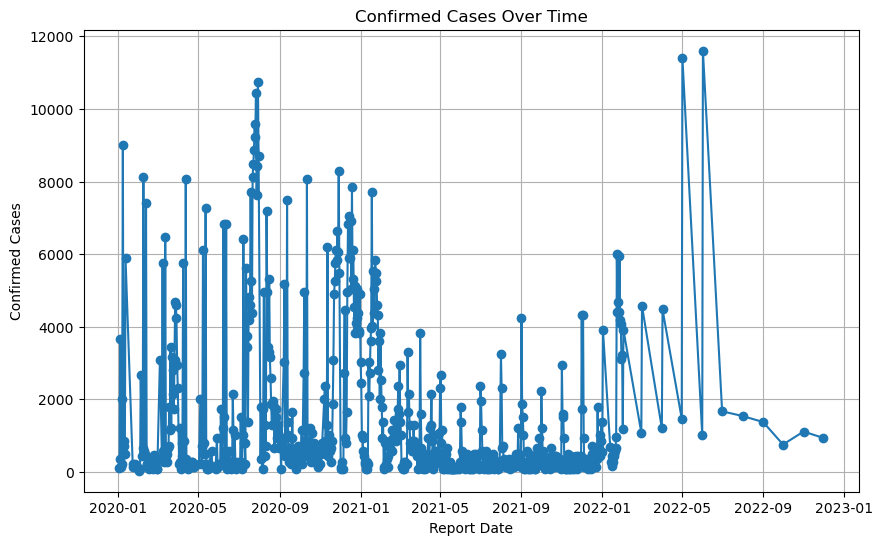

In [7]:
df['Report date'] = pd.to_datetime(df['Report date'])
plt.figure(figsize=(10, 6))
plt.plot(df['Report date'], df['Confirmed_cases'], marker='o')
plt.xlabel('Report Date')
plt.ylabel('Confirmed Cases')
plt.title('Confirmed Cases Over Time')
plt.grid()
plt.show()

In [7]:

# Load and prepare the data
df = pd.read_csv('report_after_process.csv')
df['Confirmed_cases'].describe()
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[['day', 'Confirmed_cases']])

# Create ground truth for anomalies (1 = normal, -1 = anomaly) 1467 is the mean of the confirmed cases
df['ground_truth'] = np.where(df['Confirmed_cases'] > 1467, -1, 1)
#  train model
isolation_forest = IsolationForest(contamination=0.1)
isolation_forest.fit(df_scaled)
df['if_prediction'] = isolation_forest.predict(df_scaled)

one_class_svm = OneClassSVM(nu=0.2,kernel='rbf')
one_class_svm.fit(df_scaled)
df['svm_prediction'] = one_class_svm.predict(df_scaled)

# Calculate the performance metrics for both models:
if_report = classification_report(df['ground_truth'], df['if_prediction'], output_dict=True)
svm_report = classification_report(df['ground_truth'], df['svm_prediction'], output_dict=True)

print("Isolation Forest Performance:")
print(f"Precision: {if_report['-1']['precision']}")
print(f"Recall: {if_report['-1']['recall']}")
print(f"F1-score: {if_report['-1']['f1-score']}")
print("\nOne-Class SVM Performance:")
print(f"Precision: {svm_report['-1']['precision']}")
print(f"Recall: {svm_report['-1']['recall']}")
print(f"F1-score: {svm_report['-1']['f1-score']}")

# df.Confirmed_cases.describe()



Isolation Forest Performance:
Precision: 0.8695652173913043
Recall: 0.32967032967032966
F1-score: 0.47808764940239046

One-Class SVM Performance:
Precision: 0.5766423357664233
Recall: 0.4340659340659341
F1-score: 0.4952978056426332


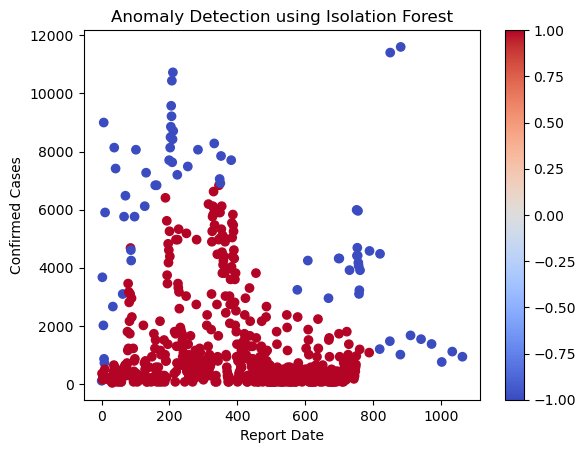

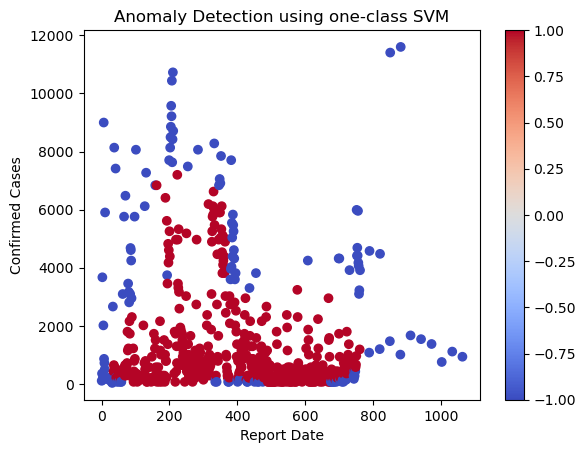

In [10]:

plt.scatter(df['day'], df['Confirmed_cases'], c=df['if_prediction'], cmap='coolwarm')
plt.colorbar()
plt.xlabel('Report Date')
plt.ylabel('Confirmed Cases')
plt.title('Anomaly Detection using Isolation Forest')
plt.show()
plt.scatter(df['day'], df['Confirmed_cases'], c=df['svm_prediction'], cmap='coolwarm')
plt.colorbar()
plt.xlabel('Report Date')
plt.ylabel('Confirmed Cases')
plt.title('Anomaly Detection using one-class SVM')
plt.show()